# Introduction to scikit-learn

## Basic preprocessing and model fitting

In this notebook, we present how to build predictive models on tabular
datasets.

In particular we will highlight:
* the difference between numerical and categorical variables;
* the importance of scaling numerical variables;
* typical ways to deal categorical variables;
* train predictive models on different kinds of data;
* evaluate the performance of a model via cross-validation.

## Introducing the dataset

To this aim, we will use data from the 1994 Census bureau database. The goal
with this data is to regress wages from heterogeneous data such as age,
employment, education, family information, etc.

Let's first load the data located in the `datasets` folder.

In [1]:
import pandas as pd

df = pd.read_csv("https://www.openml.org/data/get_csv/1595261/adult-census.csv")

# Or use the local copy:
# df = pd.read_csv('../datasets/adult-census.csv')

Let's have a look at the first records of this data frame:

In [2]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


The target variable in our study will be the "class" column while we will use
the other columns as input variables for our model. This target column divides
the samples (also known as records) into two groups: high income (>50K) vs low
income (<=50K). The resulting prediction problem is therefore a binary
classification problem.

For simplicity, we will ignore the "fnlwgt" (final weight) column that was
crafted by the creators of the dataset when sampling the dataset to be
representative of the full census database.

In [3]:
target_name = "class"
target = df[target_name].to_numpy()
target

array([' <=50K', ' <=50K', ' >50K', ..., ' <=50K', ' <=50K', ' >50K'],
      dtype=object)

In [4]:
data = df.drop(columns=[target_name, "fnlwgt"])
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States


We can check the number of samples and the number of features available in
the dataset:

In [5]:
print(
    f"The dataset contains {data.shape[0]} samples and {data.shape[1]} "
    "features"
)

The dataset contains 48842 samples and 13 features


## Working with numerical data

The numerical data is the most natural type of data used in machine learning
and can (almost) directly be fed to predictive models. We can quickly have a
look at such data by selecting the subset of columns from the original data.

We will use this subset of data to fit a linear classification model to
predict the income class.

In [6]:
data.columns

Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [7]:
data.dtypes

age                int64
workclass         object
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

In [8]:
numerical_columns = [c for c in data.columns
                     if data[c].dtype.kind in ["i", "f"]]
numerical_columns

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [9]:
data_numeric = data[numerical_columns]
data_numeric.head()

,age,education-num,capital-gain,capital-loss,hours-per-week
0,25,7,0,0,40
1,38,9,0,0,50
2,28,12,0,0,40
3,44,10,7688,0,40
4,18,10,0,0,30


When building a machine learning model, it is important to leave out a
subset of the data which we can use later to evaluate the trained model.
The data used to fit a model a called training data while the one used to
assess a model are called testing data.

Scikit-learn provides an helper function `train_test_split` which will
split the dataset into a training and a testing set. It will ensure that
the data are shuffled randomly before splitting the data.

In [10]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data_numeric, target, random_state=42
)

print(
    f"The training dataset contains {data_train.shape[0]} samples and "
    f"{data_train.shape[1]} features"
)
print(
    f"The testing dataset contains {data_test.shape[0]} samples and "
    f"{data_test.shape[1]} features"
)

The training dataset contains 36631 samples and 5 features
The testing dataset contains 12211 samples and 5 features


We will build a linear classification model called "Logistic Regression". The
`fit` method is called to train the model from the input and target data. Only
the training data should be given for this purpose.

In addition, when checking the time required to train the model and internally
check the number of iterations done by the solver to find a solution.

In [11]:
from sklearn.linear_model import LogisticRegression
import time

model = LogisticRegression(solver='lbfgs')
start = time.time()
model.fit(data_train, target_train)
elapsed_time = time.time() - start

print(
    f"The model {model.__class__.__name__} was trained in "
    f"{elapsed_time:.3f} seconds for {model.n_iter_} iterations"
)

The model LogisticRegression was trained in 0.769 seconds for [100] iterations


/home/glemaitre/Documents/packages/scikit-learn/sklearn/linear_model/logistic.py:932: ConvergenceWarning: lbfgs failed to converge (status=1): b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'. Increase the number of iterations.
  n_iter_i = _check_optimize_result(solver, opt_res, max_iter)


Let's ignore the convergence warning for now and instead let's try
to use our model to make some predictions on the first three records
of the held out test set:

In [12]:
target_predicted = model.predict(data_test)
target_predicted[:5]

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' <=50K'], dtype=object)

In [13]:
target_test[:5]

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' <=50K'], dtype=object)

In [14]:
predictions = data_test.copy()
predictions['predicted-class'] = target_predicted
predictions['expected-class'] = target_test
predictions['correct'] = target_predicted == target_test
predictions.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,predicted-class,expected-class,correct
7762,56,9,0,0,40,<=50K,<=50K,True
23881,25,9,0,0,40,<=50K,<=50K,True
30507,43,13,14344,0,40,>50K,>50K,True
28911,32,9,0,0,40,<=50K,<=50K,True
19484,39,13,0,0,30,<=50K,<=50K,True


To quantitatively evaluate our model, we can use the method `score`. It will
compute the classification accuracy when dealing with a classificiation
problem.

In [15]:
print(
    f"The test accuracy using a {model.__class__.__name__} is "
    f"{model.score(data_test, target_test):.3f}"
)

The test accuracy using a LogisticRegression is 0.818


This is mathematically equivalent as computing the average number of time
the model makes a correct prediction on the test set:

In [16]:
(target_test == target_predicted).mean()

0.8177053476373761

## Exercise 1

- What would be the score of a model that always predicts `' >50K'`?
- What would be the score of a model that always predicts `' <= 50K'`?
- Is 81% or 82% accuracy a good score for this problem?

Hint: You can compute the cross-validated of a [DummyClassifier](https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators) the performance of such baselines.

Use the dedicated notebook to do this exercise.

Let's now consider the `ConvergenceWarning` message that was raised previously
when calling the `fit` method to train our model. This warning informs us that
our model stopped learning becaused it reached the maximum number of
iterations allowed by the user. This could potentially be detrimental for the
model accuracy. We can follow the (bad) advice given in the warning message
and increase the maximum number of iterations allowed.

In [17]:
model = LogisticRegression(solver='lbfgs', max_iter=50000)
start = time.time()
model.fit(data_train, target_train)
elapsed_time = time.time() - start

In [18]:
print(
    f"The accuracy using a {model.__class__.__name__} is "
    f"{model.score(data_test, target_test):.3f} with a fitting time of "
    f"{elapsed_time:.3f} seconds in {model.n_iter_} iterations"
)

The accuracy using a LogisticRegression is 0.818 with a fitting time of 1.116 seconds in [105] iterations


We can observe now a longer training time but not significant improvement in
the predictive performance. Instead of increasing the number of iterations, we
can try to help fit the model faster by scaling the data first. A range of
preprocessing algorithms in scikit-learn allows to transform the input data
before training a model. We can easily combine these sequential operation with
a scikit-learn `Pipeline` which will chain the operations and can be used as
any other classifier or regressor. The helper function `make_pipeline` will
create a `Pipeline` by giving the successive transformations to perform.

In our case, we will standardize the data and then train a new logistic
regression model on that new version of the dataset set.

In [19]:
data_train.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,36631.000000,36631.000000,36631.000000,36631.000000,36631.000000
mean,38.642352,10.078131,1087.077721,89.665311,40.431247
std,13.725748,2.570143,7522.692939,407.110175,12.423952
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_train_scaled = scaler.fit_transform(data_train)
data_train_scaled

array([[ 0.17177061,  0.35868902, -0.14450843,  5.71188483, -2.28845333],
       [ 0.02605707,  1.1368665 , -0.14450843, -0.22025127, -0.27618374],
       [-0.33822677,  1.1368665 , -0.14450843, -0.22025127,  0.77019645],
       ...,
       [-0.77536738, -0.03039972, -0.14450843, -0.22025127, -0.03471139],
       [ 0.53605445,  0.35868902, -0.14450843, -0.22025127, -0.03471139],
       [ 1.48319243,  1.52595523, -0.14450843, -0.22025127, -2.69090725]])

In [21]:
data_train_scaled = pd.DataFrame(data_train_scaled, columns=data_train.columns)
data_train_scaled.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,3.663100e+04,3.663100e+04,3.663100e+04,3.663100e+04,3.663100e+04
mean,-2.273364e-16,1.219606e-16,3.530310e-17,3.840667e-17,1.844684e-16
std,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00
min,-1.576792e+00,-3.532198e+00,-1.445084e-01,-2.202513e-01,-3.173852e+00
25%,-7.753674e-01,-4.194885e-01,-1.445084e-01,-2.202513e-01,-3.471139e-02
50%,-1.196565e-01,-3.039972e-02,-1.445084e-01,-2.202513e-01,-3.471139e-02
75%,6.817680e-01,7.477778e-01,-1.445084e-01,-2.202513e-01,3.677425e-01
max,3.741752e+00,2.304133e+00,1.314865e+01,1.047970e+01,4.714245e+00


In [22]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
start = time.time()
model.fit(data_train, target_train)
elapsed_time = time.time() - start

In [23]:
print(
    f"The accuracy using a {model.__class__.__name__} is "
    f"{model.score(data_test, target_test):.3f} with a fitting time of "
    f"{elapsed_time:.3f} seconds in {model[-1].n_iter_} iterations"
)

The accuracy using a Pipeline is 0.818 with a fitting time of 0.174 seconds in [13] iterations


We can see that the training time and the number of iterations is much shorter
while the predictive performance (accuracy) stays the same.

In the previous example, we split the original data into a training set and a
testing set. This strategy has several issues: in the setting where the amount
of data is limited, the subset of data used to train or test will be small;
and the splitting was done in a random manner and we have no information
regarding the confidence of the results obtained.

Instead, we can use what cross-validation. Cross-validation consists in
repeating this random splitting into training and testing sets and aggregate
the model performance. By repeating the experiment, one can get an estimate of
the variabilty of the model performance.

The function `cross_val_score` allows for such experimental protocol by giving
the model, the data and the target. Since there exists several
cross-validation strategies, `cross_val_score` takes a parameter `cv` which
defines the splitting strategy.








In [24]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, data_numeric, target, cv=5)
print(f"The different scores obtained are: \n{scores}")

The different scores obtained are: 
[0.81216092 0.8096018  0.81337019 0.81326781 0.82207207]


In [25]:
print(f"The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation accuracy is: 0.814 +/- 0.004


Note that by computing the standard-deviation of the cross-validation scores
we can get an idea of the uncertainty of our estimation of the predictive
performance of the model: in the above results, only the first 2 decimals seem
to be trustworthy. Using a single train / test split would not allow us to
know anything about the level of uncertainty of the accuracy of the model.

Setting `cv=5` created 5 distinct splits to get 5 variations for the training
and testing sets. Each training set is used to fit one model which is then
scored on the matching test set. This strategy is called K-fold
cross-validation where `K` corresponds to the number of splits.

The following matplotlib code helps visualize how the datasets is partitionned
between train and test samples at each iteration of the cross-validation
procedure:

In [26]:
%matplotlib inline
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, ax, lw=20):
    """Create a sample plot for indices of a cross-validation object."""
    splits = list(cv.split(X=X, y=y))
    n_splits = len(splits)

    # Generate the training/testing visualizations for each CV split
    for ii, (train, test) in enumerate(splits):
        # Fill in indices with the training/test groups
        indices = np.zeros(shape=X.shape[0], dtype=np.int32)
        indices[train] = 1

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits + .2, -.2], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

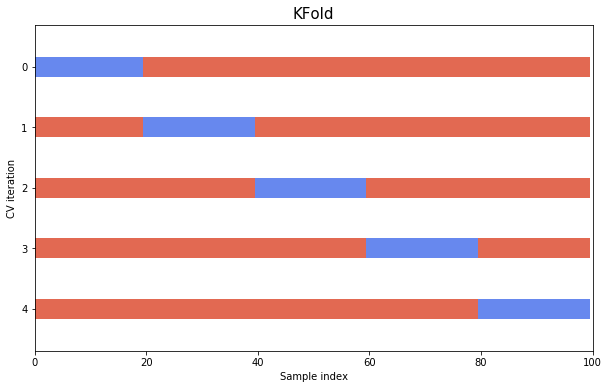

In [27]:
# Some random data points
n_points = 100
X = np.random.randn(n_points, 10)
y = np.random.randn(n_points)

fig, ax = plt.subplots(figsize=(10, 6))
cv = KFold(5)
plot_cv_indices(cv, X, y, ax);

## Working with categorical variables

As we have seen in the previous section, a numerical variable is a continuous
quantity represented by a real or integer number. Those variables can be
naturally handled by machine learning algorithms that typically composed of
a sequence of arithmetic instructions such as additions and multiplications.

By opposition, categorical variables have discrete values typically represented
by string labels taken in a finite list of possible choices. For instance, the
variable `native-country` in our dataset is a categorical variable because it
encodes the data using a finite list of possible countries (along with the `?`
marker when this information is missing):

In [28]:
data["native-country"].value_counts()

 United-States                 43832
 Mexico                          951
 ?                               857
 Philippines                     295
 Germany                         206
 Puerto-Rico                     184
 Canada                          182
 El-Salvador                     155
 India                           151
 Cuba                            138
 England                         127
 China                           122
 South                           115
 Jamaica                         106
 Italy                           105
 Dominican-Republic              103
 Japan                            92
 Guatemala                        88
 Poland                           87
 Vietnam                          86
 Columbia                         85
 Haiti                            75
 Portugal                         67
 Taiwan                           65
 Iran                             59
 Nicaragua                        49
 Greece                           49
 

In the remainder of this section, we will present different strategies to
encode categorical data into numerical data which can be used by a
machine-learning algorithm.

In [29]:
data.dtypes

age                int64
workclass         object
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

In [30]:
categorical_columns = [c for c in data.columns
                       if data[c].dtype.kind not in ["i", "f"]]
categorical_columns

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [31]:
data_categorical = data[categorical_columns]
data_categorical.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States
2,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States
3,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States
4,?,Some-college,Never-married,?,Own-child,White,Female,United-States


In [32]:
print(f"The datasets is composed of {data_categorical.shape[1]} features")

The datasets is composed of 8 features


### Encoding ordinal categories

The most intuitive strategy is to encode each category with a number.
The `OrdinalEncoder` will transform the data in such manner.

In [33]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
data_encoded = encoder.fit_transform(data_categorical)

print(f"The dataset encoded contains {data_encoded.shape[1]} features")
data_encoded[:5]

The dataset encoded contains 8 features


array([[ 4.,  1.,  4.,  7.,  3.,  2.,  1., 39.],
       [ 4., 11.,  2.,  5.,  0.,  4.,  1., 39.],
       [ 2.,  7.,  2., 11.,  0.,  4.,  1., 39.],
       [ 4., 15.,  2.,  7.,  0.,  2.,  1., 39.],
       [ 0., 15.,  4.,  0.,  3.,  4.,  0., 39.]])

We can see that all categories have been encoded for each feature
independently. We can also notice that the number of features before and after
the encoding is the same.

However, one has to be careful when using this encoding strategy. Using this
integer representation can lead the downstream models to make the assumption
that the categories are ordered: 0 is smaller than 1 which is smaller than 2,
etc.

By default, `OrdinalEncoder` uses a lexicographical strategy to map string
category labels to integers. This strategy is completely arbitrary and often be
meaningless. For instance suppose the dataset has a categorical variable named
"size" with categories such as "S", "M", "L", "XL". We would like the integer
representation to respect the meaning of the sizes by mapping them to increasing
integers such as 0, 1, 2, 3. However lexicographical strategy used by default
would map the labels "S", "M", "L", "XL" to 2, 1, 0, 3.

The `OrdinalEncoder` class accepts a "categories" constructor argument to pass
an the correct ordering explicitly.

If a categorical variable does not carry any meaningful order information then
this encoding might be misleading to downstream statistical models and you might
consider using one-hot encoding instead (see below).

Note however that the impact a violation of this ordering assumption is really
dependent on the downstream models (for instance linear models are much more
sensitive than models built from a ensemble of decision trees).

### Encoding nominal categories (without assuming any order)

`OneHotEncoder` is an alternative encoder that can prevent the dowstream
models to make a false assumption about the ordering of categories. For a
given feature, it will create as many new columns as there are possible
categories. For a given sample, the value of the column corresponding to the
category will be set to `1` while all the columns of the other categories will
be set to `0`.

In [34]:
print(f"The dataset is composed of {data_categorical.shape[1]} features")
data_categorical.head()

The dataset is composed of 8 features


,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States
2,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States
3,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States
4,?,Some-college,Never-married,?,Own-child,White,Female,United-States


In [35]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
data_encoded = encoder.fit_transform(data_categorical)
print(f"The dataset encoded contains {data_encoded.shape[1]} features")
data_encoded

The dataset encoded contains 102 features


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

Let's wrap this numpy array in a dataframe with informative column names as provided by the encoder object:

In [36]:
columns_encoded = encoder.get_feature_names(data_categorical.columns)
pd.DataFrame(data_encoded, columns=columns_encoded).head()

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Look at how the workclass variable of the first 3 records has been encoded and compare this to the original string representation.

The number of features after the encoding is than 10 times larger than in the
original data because some variables such as `occupation` and `native-country`
have many possible categories.

We can now integrate this encoder inside a machine learning pipeline as in the
case with numerical data: let's train a linear classifier on
the encoded data and check the performance of this machine learning pipeline
using cross-validation.

In [37]:
model = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)
scores = cross_val_score(model, data_categorical, target)
print(f"The different scores obtained are: \n{scores}")

The different scores obtained are: 
[0.83222438 0.83560242 0.82872645 0.83312858 0.83466421]


In [38]:
print(f"The accuracy is: {scores.mean():.3f} +/- {scores.std():.3f}")

The accuracy is: 0.833 +/- 0.002


As you can see, this representation of the categorical variables of the data is slightly more predictive of the revenue than the numerical variables that we used previously.

## Exercise 2:

- Try to fit a logistic regression model on categorical data transformed by
  the OrdinalEncoder instead. What do you observe?

Use the dedicated notebook to do this exercise.

## Using numerical and categorical variables together

In the previous sections, we saw that we need to treat data specifically
depending of their nature (i.e. numerical or categorical).

Scikit-learn provides a `ColumnTransformer` class which will dispatch some
specific columns to a specific transformer making it easy to fit a single
predictive model on a dataset that combines both kinds of variables together
(heterogeneously typed tabular data).

We can first define the columns depending on their data type:
* **binary encoding** will be applied to categorical columns with only too
  possible values (e.g. sex=male or sex=female in this example). Each binary
  categorical columns will be mapped to one numerical columns with 0 or 1
  values.
* **one-hot encoding** will be applied to categorical columns with more that
  two possible categories. This encoding will create one additional column for
  each possible categorical value.
* **numerical scaling** numerical features which will be standardized.








In [39]:
binary_encoding_columns = ['sex']
one_hot_encoding_columns = ['workclass', 'education', 'marital-status',
                            'occupation', 'relationship',
                            'race', 'native-country']
scaling_columns = ['age', 'education-num', 'hours-per-week',
                   'capital-gain', 'capital-loss']

We can now create our `ColumnTransfomer` by specifying a list of triplet
(preprocessor name, transformer, columns). Finally, we can define a pipeline
to stack this "preprocessor" with our classifier (logistic regression).

In [40]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('binary-encoder', OrdinalEncoder(), binary_encoding_columns),
    ('one-hot-encoder', OneHotEncoder(handle_unknown='ignore'),
     one_hot_encoding_columns),
    ('standard-scaler', StandardScaler(), scaling_columns)
])
model = make_pipeline(
    preprocessor,
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

The final model is more complex than the previous models but still follows the
same API:
- the `fit` method is called to preprocess the data then train the classifier;
- the `predict` method can make predictions on new data;
- the `score` method is used to predict on the test data and compare the
  predictions to the expected test labels to compute the accuracy.

In [41]:
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42
)
model.fit(data_train, target_train)
model.predict(data_test)[:5]

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' >50K'], dtype=object)

In [42]:
target_test[:5]

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' <=50K'], dtype=object)

In [43]:
data_test.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
7762,56,Private,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,0,40,United-States
23881,25,Private,HS-grad,9,Married-civ-spouse,Transport-moving,Own-child,Other,Male,0,0,40,United-States
30507,43,Private,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,14344,0,40,United-States
28911,32,Private,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
19484,39,Private,Bachelors,13,Married-civ-spouse,Sales,Wife,White,Female,0,0,30,United-States


In [44]:
model.score(data_test, target_test)

0.8577512079272787

This model can also be cross-validated as usual (instead of using a single
train-test split):

In [45]:
scores = cross_val_score(model, data, target, cv=5)
print(f"The different scores obtained are: \n{scores}")

The different scores obtained are: 
[0.85116184 0.8498311  0.84756347 0.85268223 0.85513923]


In [46]:
print(f"The accuracy is: {scores.mean():.3f} +- {scores.std():.3f}")

The accuracy is: 0.851 +- 0.003


The compound model has a higher predictive accuracy than the
two models that used numerical and categorical variables in
isolation.

# Fitting a more powerful model

Linear models are very nice because they are usually very cheap to train,
small to deploy, fast to predict and give a good baseline.

However it is often useful to check whether more complex models such as
ensemble of decision trees can lead to higher predictive performance.

In the following we try a scalable implementation of the Gradient Boosting
Machine algorithm. For this class of models, we know that contrary to linear
models, it is useless to scale the numerical features and furthermore it is
both safe and significantly more computationally efficient use an arbitrary
integer encoding for the categorical variable even if the ordering is
arbitrary. Therefore we adapt the preprocessing pipeline as follows:

In [47]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# For each categorical column, extract the list of all possible categories
# in some arbritrary order.
categories = [data[column].unique() for column in data[categorical_columns]]

preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(categories=categories), categorical_columns),
], remainder="passthrough")

model = make_pipeline(preprocessor, HistGradientBoostingClassifier())
model.fit(data_train, target_train)
print(model.score(data_test, target_test))

0.8801080992547703


We can observe that we get significantly higher accuracies with the Gradient
Boosting model. This is often what we observe whenever the dataset has a large
number of samples and limited number of informative features (e.g. less than
1000) with a mix of numerical and categorical variables.

This explains why Gradient Boosted Machines are very popular among datascience
practitioners who work with tabular data.








## Exercise 3:

- Check that scaling the numerical features does not impact the speed or
  accuracy of HistGradientBoostingClassifier
- Check that one-hot encoding the categorical variable does not improve the
  accuracy of HistGradientBoostingClassifier but slows down the training.

Use the dedicated notebook to do this exercise.